In [1]:
import glob
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image

from utils import scale_proportional
from segmentations import binary_segmentation, otsu_segmentation

In [4]:
!wget -O dataset.zip "https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0" -nc
!mkdir -p dataset
!unzip -q dataset.zip -d dataset

--2023-11-22 17:02:57--  https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0
Resolvendo database.cric.com.br (database.cric.com.br)... 

200.239.128.168
Conectando-se a database.cric.com.br (database.cric.com.br)|200.239.128.168|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: não especificada [application/zip]
Salvando em: ‘dataset.zip’

dataset.zip             [             <=>    ] 807,34M  1,73MB/s    em 9m 38s  

2023-11-22 17:12:37 (1,40 MB/s) - ‘dataset.zip’ salvo [846562084]



In [2]:
df = pd.read_csv('./classifications.csv')
dir_path = './dataset'
test_img = '0a2a5a681410054941cc56f51eb8fbda.png'
df[df['image_filename'] == test_img]

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
5635,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5636,Negative for intraepithelial lesion,1012,875
5636,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5637,Negative for intraepithelial lesion,910,900
5637,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5638,Negative for intraepithelial lesion,1177,416
5638,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5639,Negative for intraepithelial lesion,1254,366
5639,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5640,LSIL,983,450


In [3]:
def crop_image_around_point(image, x, y, crop_size):
    # Calculate the top-left corner of the crop
    x_start = max(0, x - int(crop_size / 2))
    y_start = max(0, y - int(crop_size / 2))

    # Calculate the bottom-right corner of the crop
    x_end = min(image.shape[1], x + int(crop_size / 2))
    y_end = min(image.shape[0], y + int(crop_size / 2))

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    return cropped_image

In [4]:
def crop_with_pil(image, x, y, crop_size):
    lcrop = int(crop_size/2)
    rcrop = int(crop_size - lcrop)
    width, height = image.size

    # Calculate the top-left corner of the crop
    x_start = max(0, x - lcrop)
    y_start = max(0, y - lcrop)

    # Calculate the bottom-right corner of the crop
    x_end = min(width, x + rcrop)
    y_end = min(height, y + rcrop)

    # Crop the image
    cropped_image = image.crop((x_start, y_start, x_end, y_end))

    return cropped_image

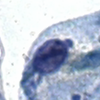

In [100]:
img_path = os.path.join(dir_path, test_img)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_img = crop_image_around_point(image, 1012, 875, 100)
Image.fromarray(cropped_img)

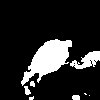

In [101]:
binary = binary_segmentation(cropped_img, 127, invert=True)
Image.fromarray(binary)

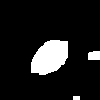

In [102]:
kernel = np.ones((3,3),np.uint8)
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=3)
Image.fromarray(opened)

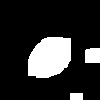

In [103]:
dilated = cv2.morphologyEx(opened, cv2.MORPH_DILATE, kernel, iterations=3)
Image.fromarray(dilated)

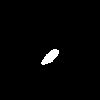

In [104]:
dist_transform = (cv2.distanceTransform(opened, cv2.DIST_L2, 5))
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(dilated,sure_fg)
Image.fromarray(cv2.bitwise_and(dilated,sure_fg))

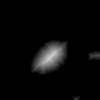

In [105]:
Image.fromarray(np.uint8(dist_transform * 15))

In [106]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

In [107]:
np.unique(markers)

array([0, 1, 2], dtype=int32)

In [109]:
markers = (cv2.watershed(cropped_img, markers))
cropped_img[markers == -1] = [255,0,0]

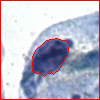

In [111]:
# https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#ga25c259e7e2fa2ac70de4606ea800f12f
Image.fromarray(cropped_img)

In [75]:
np.unique(markers.flatten(), return_counts=True)

(array([0, 1], dtype=int32), array([9846,  154]))

hi


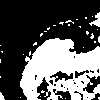

In [11]:
Image.fromarray(otsu_segmentation(cropped_img, invert=True))

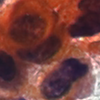

In [52]:
crop_size = 100
out_dir = './cropped_dataset/'

for index, row in df.iterrows():
    x = row.nucleus_x
    y = row.nucleus_y
    id = row.cell_id
    label = row.bethesda_system
    img_path = os.path.join(dir_path, row.image_filename)
    cropped_img_path = os.path.join(out_dir, label, str(id)+'.jpg')

    image = Image.open(img_path)
    cropped_img = crop_with_pil(image, x, y, crop_size)
    # cropped_img.save(cropped_img_path)
    break
cropped_img

In [22]:
# Example usage:
# Load your image (replace 'your_image_path.jpg' with your actual image file path)
original_image = cv2.imread(img_path)

if original_image is None:
    print("erro")
else:
    # Replace these values with the actual x, y coordinates and the desired crop size
    center_x = 1254
    center_y = 366
    crop_size = 100

    # Crop the image around the specified x, y coordinates
    cropped_image = crop_image_around_point(original_image, center_x,  center_y, crop_size)

    # Display the original and cropped images
    cv2.imwrite('./tests/ouput.png', cropped_image)
